# Clustering - Tuto 1

In this tuto we play with a realistic 1D dataset: Vertical mean temperature from Argo data

We use clustering with GMM to analyse the PDF of the dataset.

The goal is to understand better how GMM works, and its limitations.

The optimal number of clusters is determined with BIC and independant samples issues are demonstrated

(c) G. Maze


***
*First, let's make sure the Python env is correct to run this notebook*:

In [1]:
import os, sys, urllib, tempfile
with tempfile.TemporaryDirectory() as local:
    sys.path.append(local)
    urllib.request.urlretrieve("https://raw.githubusercontent.com/obidam/ds2-2025/main/utils.py", os.path.join(local, "utils.py"))
    urllib.request.urlretrieve("https://raw.githubusercontent.com/obidam/ds2-2025/main/practice/exploratory_statistics/tuto_tools.py", os.path.join(local, "tuto_tools.py"))
    from utils import check_up_env
    ds2tools = check_up_env(with_tuto=True)
    create_map = ds2tools.create_map
    gaussian = ds2tools.gaussian
    plot_normal = ds2tools.plot_normal

/var/folders/ww/psmkfjds7xsc4kjsz66ghldr000nsn/T/tmp4e5pav2_/utils.py:69: UserWarning: 
Running on your own environment
Make sure to have all necessary packages installed
See:   https://github.com/obidam/ds2-2025/blob/main/practice/environment/coiled/environment-coiled-pinned-binder.yml
  warnings.warn("\nRunning on your own environment\nMake sure to have all necessary packages installed\nSee:   https://github.com/obidam/ds2-2025/blob/main/practice/environment/coiled/environment-coiled-pinned-binder.yml")


In [7]:
# Libraries import section
import os, sys

import xarray as xr
import numpy as np
from scipy import stats
from scipy import signal
from intake import open_catalog

from sklearn import preprocessing
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

import matplotlib as mpl
# matplotlib.use('agg')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="deep", color_codes=True)

# Load data

From Google cloud storage [see specific tuto here](https://github.com/obidam/ds2-2023/blob/main/practice/environment/02-Access_to_data_in_the_cloud.ipynb).

We work with a 1-dimensional dataset: local 0-2000m vertical mean measurements (eg: temperature, salinity), from Argo floats.

In [3]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2025/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)
ds = cat['argo_global_vertical_mean'].read_chunked()
print('This dataset holds: %.3f GB' % (ds.nbytes / 1e9))
print(ds)

This dataset holds: 0.003 GB
<xarray.Dataset>
Dimensions:    (N_PROF: 67010)
Coordinates:
    LATITUDE   (N_PROF) float32 dask.array<chunksize=(33505,), meta=np.ndarray>
    LONGITUDE  (N_PROF) float32 dask.array<chunksize=(33505,), meta=np.ndarray>
    TIME       (N_PROF) datetime64[ns] dask.array<chunksize=(33505,), meta=np.ndarray>
Dimensions without coordinates: N_PROF
Data variables:
    BRV2       (N_PROF) float32 dask.array<chunksize=(33505,), meta=np.ndarray>
    DBINDEX    (N_PROF) float64 dask.array<chunksize=(33505,), meta=np.ndarray>
    PSAL       (N_PROF) float32 dask.array<chunksize=(33505,), meta=np.ndarray>
    SIG0       (N_PROF) float32 dask.array<chunksize=(33505,), meta=np.ndarray>
    TEMP       (N_PROF) float32 dask.array<chunksize=(33505,), meta=np.ndarray>


/Users/gmaze/miniconda3/envs/ds2-coiled-2025-binder/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


# Stats for 1D data

In [4]:
X, Xlabel = ds['TEMP'], "VERTICAL MEAN TEMP"
# X = X[np.where(X>3)]
print(X)
print(Xlabel)
print(X.shape)

<xarray.DataArray 'TEMP' (N_PROF: 67010)>
dask.array<open_dataset-TEMP, shape=(67010,), dtype=float32, chunksize=(33505,), chunktype=numpy.ndarray>
Coordinates:
    LATITUDE   (N_PROF) float32 dask.array<chunksize=(33505,), meta=np.ndarray>
    LONGITUDE  (N_PROF) float32 dask.array<chunksize=(33505,), meta=np.ndarray>
    TIME       (N_PROF) datetime64[ns] dask.array<chunksize=(33505,), meta=np.ndarray>
Dimensions without coordinates: N_PROF
VERTICAL MEAN TEMP
(67010,)


Text(0.5, 1.0, 'VERTICAL MEAN TEMP')

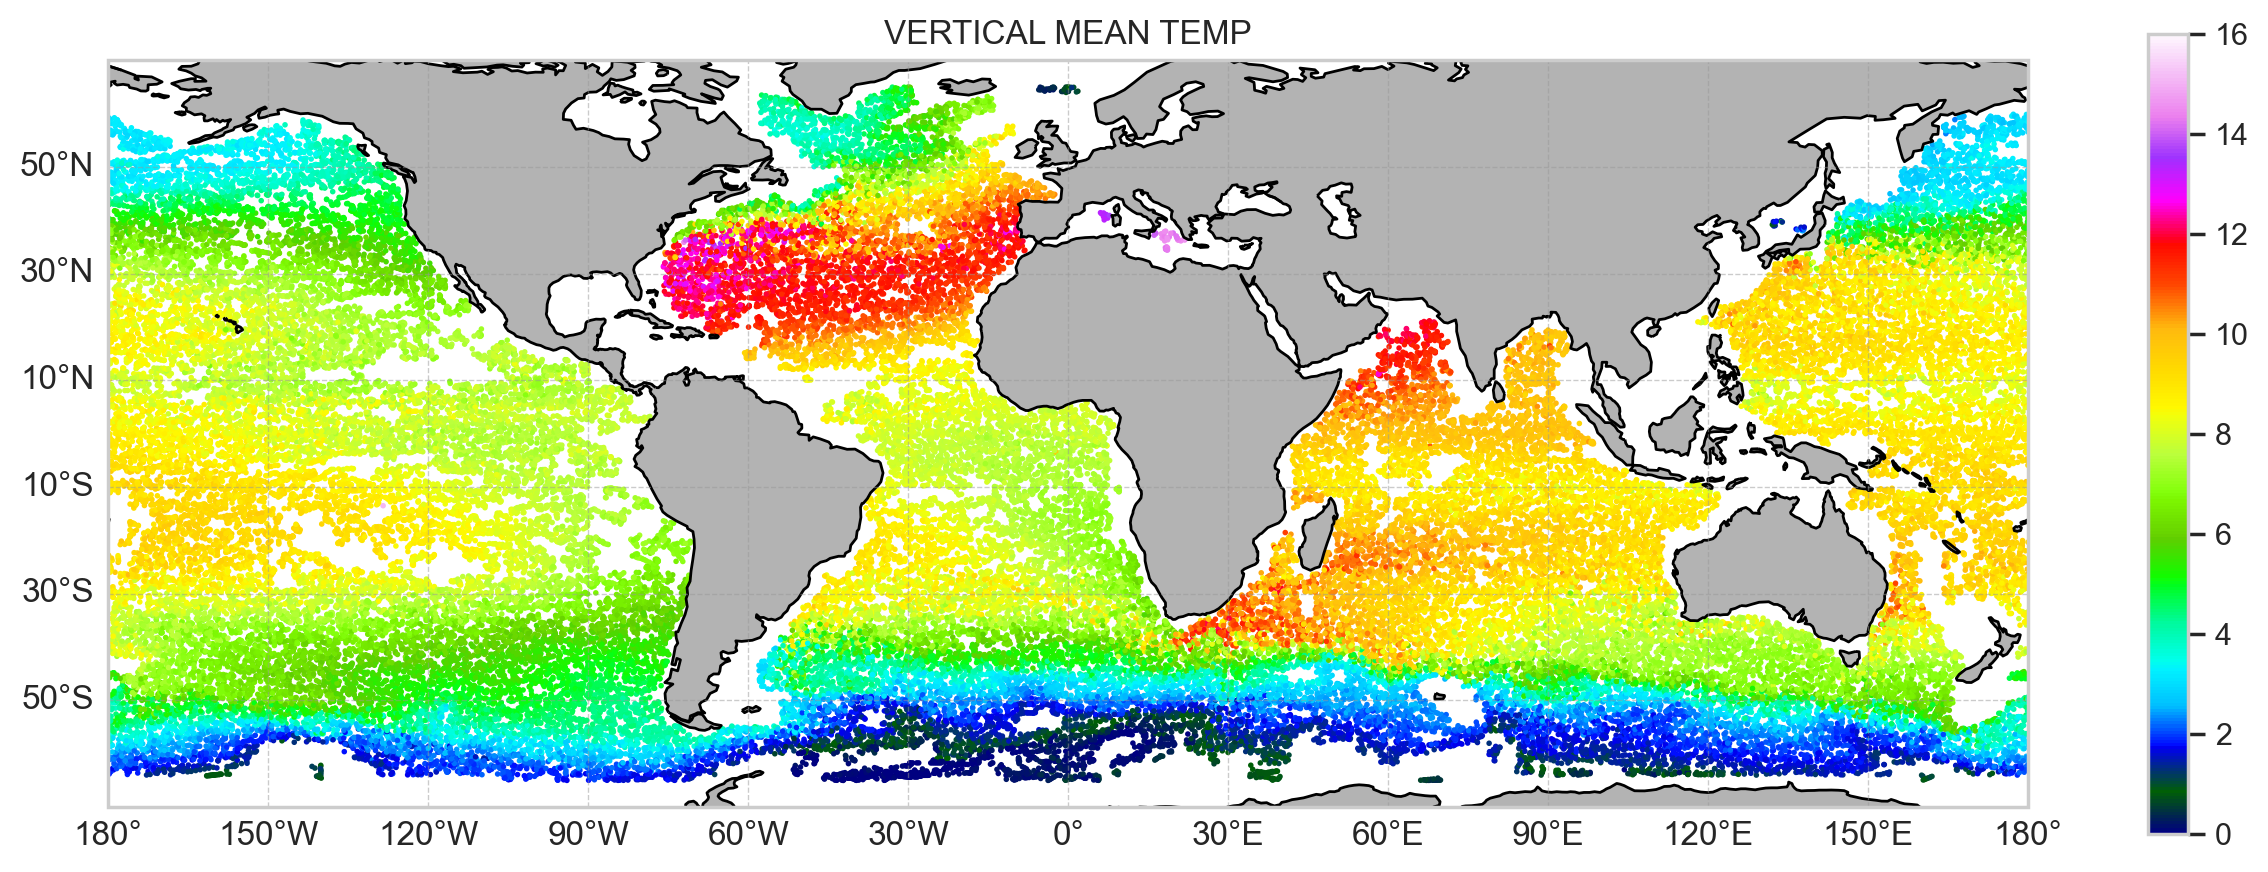

In [8]:
fig, proj, ax = create_map()
plt.scatter(X.LONGITUDE, X.LATITUDE, 1, X, cmap=mpl.colormaps.get_cmap('gist_ncar'), vmin=0, vmax=16)
plt.colorbar()
plt.title(Xlabel)

<Axes: title={'center': 'Histogram'}, ylabel='Count'>

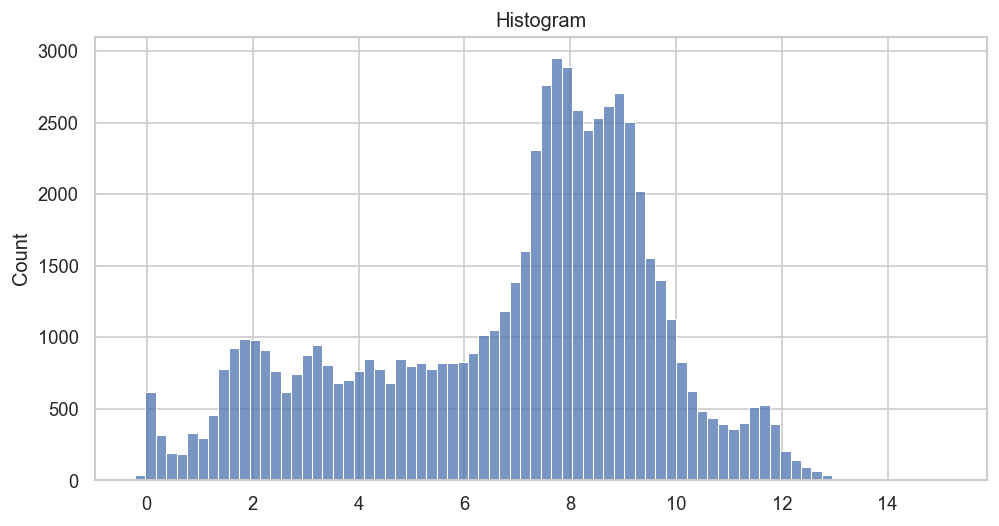

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.5), dpi=120)
axes.set_title('Histogram')
sns.histplot(X, ax=axes)

# Pre-process data

Normalisation step

In [7]:
%%time
# From xarray, X has shape: (N_PROF,)
# For scikit-learn we need X with shape: [N_PROF,1]
X0 = X.values[np.newaxis].T
print("Data shape [n_samples, n_features]:", X0.shape) # shape [n_samples, n_features=1]

# Fit the scaler object:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X0)

# The mean and std profiles are in the scaler object properties:
X_ave = scaler.mean_
X_std = scaler.scale_
print("Data mean, std:", X_ave, X_std)

# Normalize data:
Xn = scaler.transform(X0)       

# Here, we only center data:
Xc = preprocessing.StandardScaler(with_std=False).fit(X0).transform(X0)

Data shape [n_samples, n_features]: (67010, 1)
Data mean, std: [6.82879763] [2.82974902]
CPU times: user 11.3 ms, sys: 4.31 ms, total: 15.6 ms
Wall time: 123 ms


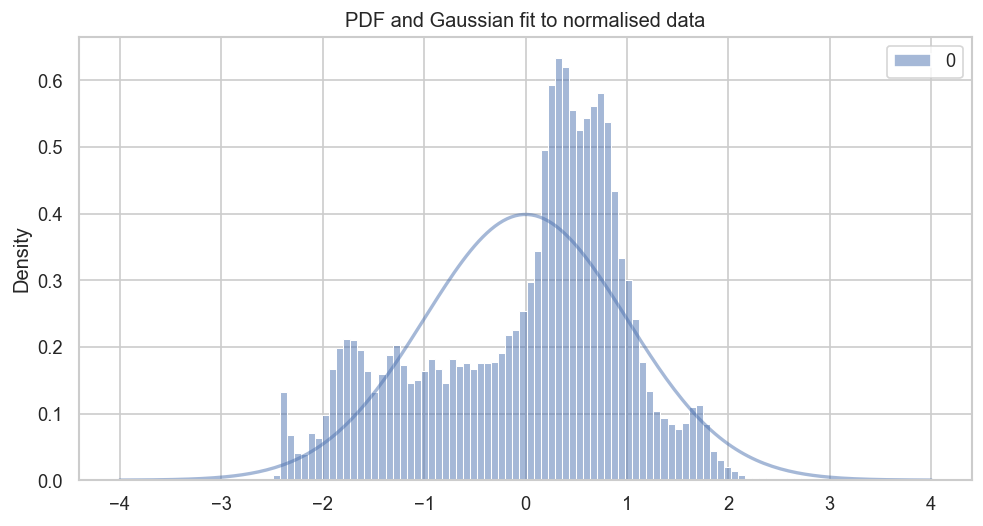

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.5), dpi=120)
axes.set_title('PDF and Gaussian fit to normalised data')
ax = sns.histplot(Xn, stat='density', kde=False)
plot_normal(np.mean(Xn), np.std(Xn), color=ax.patches[-1].get_facecolor())

# Clustering in 1D

Clearly from the figure above, one can see that the dataset is not Gaussian and exhibits several modes. In other words, data samples agregated into several clusters.

Let's identify them

## Use a GMM to identify modes (the "clusters") in the distribution

In [9]:
from sklearn.mixture import GaussianMixture as GMM

# Clustering with GMM:
classifier = GMM(n_components=4)
classifier = classifier.fit(Xn)
print(classifier)

GaussianMixture(n_components=4)


In [10]:
# Predict class labels:
labels = classifier.predict(Xn)
print(labels)

[1 1 1 ... 1 1 1]


In [11]:
# See more about clusters:
n_clusters = np.unique(labels).shape[0]
for k in range(n_clusters):
    print("Cluster %i mean(std), weight: %0.2f (%0.2f), %0.2f"%(k, 
                                                                classifier.means_[k,0], 
                                                                classifier.covariances_[k,0],
                                                                classifier.weights_[k]))
print(np.sum(classifier.weights_)) # Must be 1.

Cluster 0 mean(std), weight: 0.97 (0.24), 0.24
Cluster 1 mean(std), weight: -1.64 (0.15), 0.18
Cluster 2 mean(std), weight: 0.42 (0.10), 0.41
Cluster 3 mean(std), weight: -0.62 (0.15), 0.17
0.9999999999999999


/var/folders/ww/psmkfjds7xsc4kjsz66ghldr000nsn/T/ipykernel_54786/417005366.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Cluster %i mean(std), weight: %0.2f (%0.2f), %0.2f"%(k,


In [12]:
# Compute the GMM dataset pdf:
x = np.linspace(-3,3,200)
gmm_pdf = np.zeros(x.shape)
for k in range(n_clusters):
    gmm_pdf += classifier.weights_[k]*gaussian(x, 
                                               classifier.means_[k,0], 
                                               classifier.covariances_[k,0])    

/var/folders/ww/psmkfjds7xsc4kjsz66ghldr000nsn/T/ipykernel_54786/4152507702.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label="$\lambda_%i=%0.0f$%%: $\mu_%i$=%0.2f ($\sigma^2_%i=%0.2f$)"%(k,


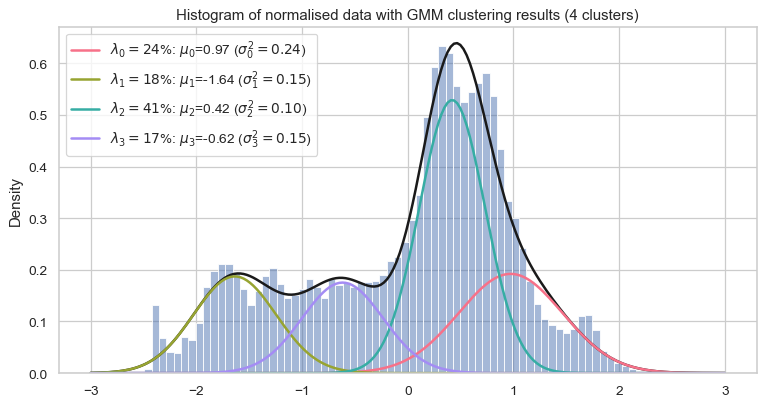

In [13]:
colors = sns.husl_palette(n_clusters)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
ax = sns.histplot(Xn, stat='density', kde=False, ax=ax)
ax.set_title('Histogram of normalised data with GMM clustering results (%i clusters)' % n_clusters)
plt.plot(x,gmm_pdf,'k', linewidth=2)
for k, col in zip(range(n_clusters),colors):
    plt.plot(x,classifier.weights_[k]*
             gaussian(x, classifier.means_[k,0], classifier.covariances_[k,0]),\
             color=col, linewidth=2, 
             label="$\lambda_%i=%0.0f$%%: $\mu_%i$=%0.2f ($\sigma^2_%i=%0.2f$)"%(k, 
                                                    classifier.weights_[k]*100, k, 
                                                    classifier.means_[k,0], k, 
                                                    classifier.covariances_[k,0]))
plt.legend()

## How to select the nb of cluster ?

This is the most problematic question in clustering.

It is a rather difficult problem to determine automatically the most appropriate number of components. There exist different methods that are mostly based on estimating the most probable K, or minimizing a given metric such as the mixture entropy or misfit with the observed PDF (Fraley et al., 1998). A popular method is the Bayesian Information Criterion (BIC, Schwarz, 1978). The BIC is an empirical approach of the model probability computed as:

$$BIC(K) = -2\,\mathcal{L}(K) + N_f(K)\,\log(n) \label{eq:bic}$$

where $\mathcal{L}(K)$ is the log likelihood of the trained model with $K$ classes, $N_f(K)=K-1+K\,D+K\,D\,(D+1)/2$ is the number of independent parameters to be estimated (the sum of the component weights, Gaussian means and covariance matrix elements in the D-dimensional data space) and $n$ is the number of profiles used to train the model.

The BIC is empirical because the first r.h.s. term decreases as the number of classes K increases while the second r.h.s. term is a penalty term that increases with K and thus prevents model overfitting the data. The sum of the two terms is expected to exhibit a minimum for the most appropriate $K$.

In [14]:
kmax = 20
BIC = np.zeros((kmax))
BICf = np.zeros((kmax))

print(Xn.shape[0])
n = Xn.shape[0] # Nb of samples
n = 900
n = 2196

for k in range(kmax):
    print(k, kmax)
    this_gmm = GMM(n_components=k+1).fit(Xn)
    BIC[k] = this_gmm.bic(Xn)
    D = 1 # Nb of dimension
    Nf = (k+1)-1 + (k+1)*D + (k+1)*D*(D+1)/2 # Nb of independant parameters to estimate
#     print Nf, this_gmm._n_parameters()
    BICf[k] = -2*n*this_gmm.score(Xn) + Nf*np.log(n)

67010
0 20
1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
9 20
10 20
11 20
12 20
13 20
14 20
15 20
16 20
17 20
18 20
19 20


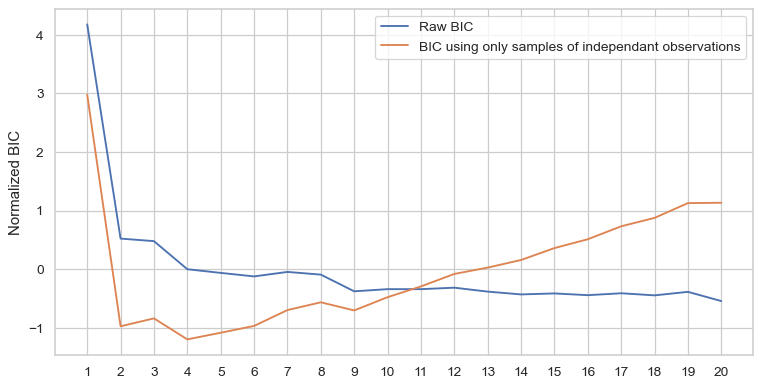

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
plt.plot(np.arange(kmax)+1,(BIC-np.mean(BIC))/np.std(BIC),label='Raw BIC')
plt.plot(np.arange(kmax)+1,(BICf-np.mean(BICf))/np.std(BICf), label='BIC using only samples of independant observations')
plt.ylabel('Normalized BIC')
plt.xticks(np.arange(kmax)+1)
plt.legend()

In [16]:
# Since we have more observations than the maximum independant sample size, 
# we can run several BIC computations
kmax = 20
Nrun = 30
BIC = np.zeros((kmax,Nrun))
BICf = np.zeros((kmax,Nrun))

print(Xn.shape[0])
n = Xn.shape[0] # Nb of samples
n = 2196 # Nb of independant samples

for run in range(Nrun):
    print(run, Nrun)
    for k in range(kmax):
        ii = np.random.choice(range(X.shape[0]), n, replace=False)
        this_gmm = GMM(n_components=k+1).fit(Xn[ii])
        BIC[k,run] = this_gmm.bic(Xn[ii])
        D = 1 # Nb of dimension
        Nf = (k+1)-1 + (k+1)*D + (k+1)*D*(D+1)/2 # Nb of independant parameters to estimate
    #     print Nf, this_gmm._n_parameters()
        BICf[k,run] = -2*n*this_gmm.score(Xn[ii]) + Nf*np.log(n)

67010
0 30
1 30
2 30
3 30
4 30
5 30
6 30
7 30
8 30
9 30
10 30
11 30
12 30
13 30
14 30
15 30
16 30
17 30
18 30
19 30
20 30
21 30
22 30
23 30
24 30
25 30
26 30
27 30
28 30
29 30


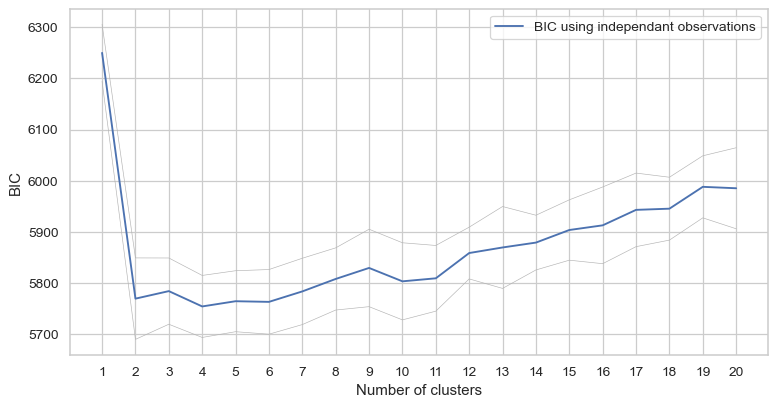

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
BICfmean = np.mean(BICf,axis=1)
BICfstd = np.std(BICf,axis=1)
normBICfmean = (BICfmean-np.mean(BICfmean))/np.std(BICfmean)
plt.plot(np.arange(kmax)+1,BICfmean, 
         label='BIC using independant observations')
plt.plot(np.arange(kmax)+1,BICfmean+BICfstd,color=[0.7]*3,linewidth=0.5)
plt.plot(np.arange(kmax)+1,BICfmean-BICfstd,color=[0.7]*3,linewidth=0.5)
plt.ylabel('BIC')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(kmax)+1)
plt.legend()

## Exercise

Change the nb of clusters in the GMM.

What happens when K=2 ?